# 內容
搭建一個能識別驗證碼的模型（CNN + CTC Loss）

# 目的
- 了解如何結合 CNN 與 CTC Loss

In [ ]:
# 若使用 Colab，可以先 run 這邊的 code

# 假如要連結自己的雲端硬碟再開啟
# from google.colab import drive
# drive.mount('/content/gdrive')

# 檢查GPU
# !nvidia-smi

# 安裝產生驗證碼的套件
# !pip install captcha

# 產生驗證碼

In [ ]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # 在 Retina 螢幕中顯示模糊的效果

import string
# 驗證碼字符包含 0 ~ 10 數字以及 26 個英文字母
characters = string.digits + string.ascii_uppercase
# print(characters)

# 設定產生圖片尺寸和總類別
# number_class + 1 是因為有多一個類別：空格
width, height, number_len, number_class = 170, 80, 4, len(characters) + 1

# 設定產生驗證碼的 generator
generator = ImageCaptcha(width=width, height=height)

# 固定 4 字長度的驗證碼
random_string = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_string)

plt.imshow(img)
plt.title(random_string)

搭建一個 CNN 模型，使得 feature Map 高度被壓縮為 1、且寬度為 13

In [97]:
from keras import backend as K
import keras

# CTC Loss funciton 需要四個參數，分別是：
# 預測
# Label
# CNN output 的寬度
# 預測圖片所包含文字長度

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [107]:
from keras.models import *
from keras.layers import *

rnn_size = 128

input_tensor = Input((height, width, 3))
x = input_tensor

# 設計 CNN 架構
for i in range(4):
    i += 1
    x = Conv2D(filters=64 * i, kernel_size=(3, 3), padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)

# 記錄 CNN 的輸出尺寸，以利後面的 CTC Loss 的轉換
# conv_shape = (Batch_size, 輸出高度, 輸出寬度, 輸出深度)
conv_shape = x.get_shape()

# 從 (Batch_size, 高度, 寬度, 深度) 變成 (Batch_size, 寬度, 深度 × 高度)，以符合 CTC Loss 需求
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1] * conv_shape[3])))(x)

x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(number_class, activation='softmax')(x)

# 用來預測的 model
base_model = Model(input=input_tensor, output=x)

# 設定要給 CTC Loss 的資訊
labels = Input(name='labels', shape=[number_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# Lambda layer 代表對數據做變換，且不需學習參數
ctc_loss = Lambda(ctc_lambda_func, output_shape=(1, ), name='ctc')([x, labels, input_length, label_length])

# 用來計算 loss 的 model
model = Model(input=[input_tensor, labels, input_length, label_length], output=[ctc_loss])

# 由於目前 Model 的 output（y_pred） 為 CTC Loss
# 因此在 Loss 的 y_true, y_pred 中，我們只需要 y_pred，並當作 loss 的值
# 所以才使用 lambda y_true, y_pred: y_pred
# 至於為什麼會有 y_true, y_pred
# 請參考 https://towardsdatascience.com/advanced-keras-constructing-complex-custom-losses-and-metrics-c07ca130a618
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='SGD')

C:\Users\x2206\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
Tensor("ctc_7/ExpandDims:0", shape=(None, 1), dtype=float32)
C:\Users\x2206\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [99]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 80, 170, 64)  1792        input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_29 (MaxPooling2D) (None, 40, 85, 64)   0           conv2d_37[0][0]                  
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 40, 85, 64)   256         max_pooling2d_29[0][0]           
___________________________________________________________________________________________

In [103]:
# 使用 generator 來產生 training data
# 產生包含要給 loss 的資訊
# x = 輸入圖片
# np.ones(batch_size) * int(conv_shape[2]) = CNN 輸出 feature map 寬度
# np.ones(batch_size) * nunmber_len = 字串長度(可浮動)

def generator(batch_size=128):
    x = np.zeros((batch_size,height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, number_len), dtype=np.uint8)

    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            
            x[i] = np.array(generator.generate_image(random_str))
            y[i] = [characters.find(x) for x in random_str] # 尋找字符相對應的 label

        # 有著 yield 的 function 變為 generator
        # 詳細請參考 https://blog.csdn.net/mieleizhi0522/article/details/82142856
        yield [x, y, np.ones(batch_size) * int(conv_shape[2]), np.ones(batch_size) * number_len], np.ones(batch_size)

In [102]:
generator = generator(batch_size=1)
test_generator = next(generator)
plt.imshow(test_generator[0][0][0])
print('Label：', test_generator[0][1])
print('CNN 輸出寬度：', test_generator[0][2])
print('字串長度（可浮動）: ', test_generator[0][3])

TypeError: 'generator' object is not callable

## 開始訓練

In [ ]:
model.fit_generator(generator(batch_size=32), steps_per_epoch=300, epochs=60)

## 預測

decode CTC 的設計

In [100]:
def ctc_decode(y_predict):
    word = ''

    # 將第一個區域初始化為空格
    previous_word = 0

    for single_result in y_predict[0].argmax(1):
        # 如果不是空格
        if single_result > 0:
            # 如果和上一個區域是同樣字符，則不採用
            if previous_word != single_result:
                word += characters[single_result]

        previous_word = single_result
    
    return word

Text(0.5, 1.0, 'pred:SUZ\nlabel:6YYG')

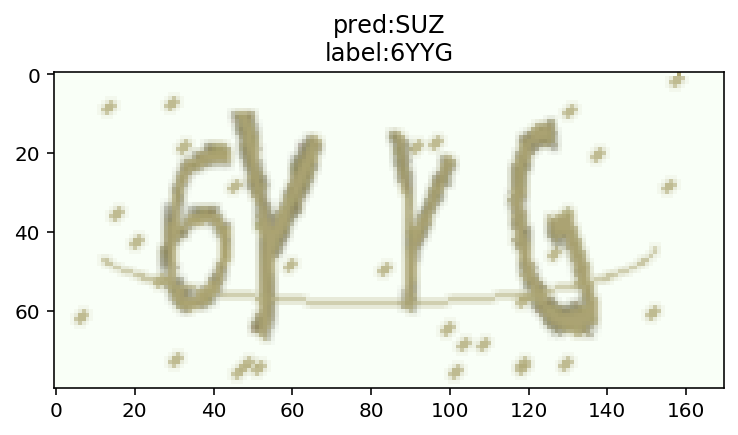

In [104]:
characters2 = characters + ' '

# 只需要 x_test 和 y_test
[x_test, y_test, _, _], _  = next(generator(batch_size=1))
y_predict = base_model.predict(x_test)

# argmax()：沿著 martix 的某 aixs，尋找其最大值的 index
# print(np.argmax(y_predict, axis=2)[0])

# 使用 ctc_decode 來得到解答
# pred_output = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0]) * y_pred.shape[1])[0][0])
# pred_output = ''.join([characters[x] for x in pred_output[0]])
y_predict = ctc_decode(y_predict)
y_test = ''.join([characters[x] for x in y_test[0]])

plt.imshow(x_test[0])
plt.title('pred:{}\nlabel:{}'.format(str(y_predict), str(y_test)))

# 補充：CRNN 架構


In [ ]:
from keras.models import *
from keras.layers import *

rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor

for i in range(4):
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)

    if i < 3:
        x = MaxPooling2D(pool_size=(2, 2))(x)
    else:
        x = MaxPooling2D(pool_size=(2, 1))(x)

conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1] * conv_shape[3])))(x)
x = Dense(32, activation='relu')(x)

# GRU is meaning Gate recurrent unit
gru_1 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, init='he_normal', name='gru1_b')(x)
gru_1_merged = keras.layers.add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru2')(gru_1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru2_b')(gru_1_merged)

x = keras.layers.Concatenate()([gru_2, gru_2b])
x = Dropout(0.25)(x)
x = Dense(number_class, init='he_normal', activation='softmax')(x)

base_model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[number_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1, ), name='ctc')([x, labels, input_length, label_length])

model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='Adam')

In [ ]:
model.summary()